In [1]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
# %matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl

# Set some user-specific variables
# MAIN_FOLDER = '../' # relative path to project folder
# FIG_FOLDER = 'figures/' # relative path to figure

# functions definitions:

In [2]:
def error_in_attitude(my_times, Solver, gaia):
    error_in_attitude = 0
    for t in my_times:
        agis_att = Solver.get_attitude(t)
        gaia_att = gaia.func_attitude(t)
        diff_att = gaia_att - agis_att
        error_in_attitude += diff_att.compute_magnitude()
    return error_in_attitude

# Initializing objects:

In [3]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 1/60/60
t_end = t_init + 1/24/60 # 365*5
my_dt = 1/24/60/60 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')
my_times = np.linspace(t_init, t_end, num=100, endpoint=False)
real_sources = []
calc_sources = []
for t in my_times:
    alpha, delta = generate_observation_wrt_attitude(gaia.func_attitude(t))
    real_src_tmp = Source(str(t),np.degrees(alpha), np.degrees(delta), 0, 0, 0, 0)
    calc_src_tmp = Calc_source('calc_'+str(t), [t], real_src_tmp.get_parameters()[0:5], real_src_tmp.get_parameters()[5])
    real_sources.append(real_src_tmp)
    calc_sources.append(calc_src_tmp)
print('Sources created!')

Sat created
Sources created!


len(real_sources):  100


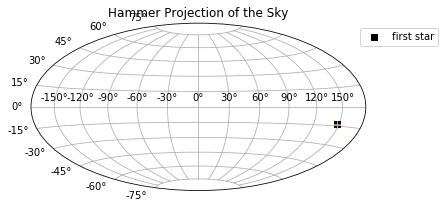

In [103]:
plt.figure()
plt.subplot(111, projection="hammer")
alphas = []
deltas = []
#print('my_times: ', my_times)
print('len(real_sources): ', len(real_sources))
for i, s in enumerate(real_sources):
    alpha, delta = s.alpha-np.pi, s.delta
    #print(i, alpha, delta)
    alphas.append(alpha)
    deltas.append(delta)
    if i==0:
        plt.plot(alpha, delta, 'sk', label='first star')
    else:
        plt.plot( alpha, delta,'+')

plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)

In [104]:
# test if source and calc source are equal (as they should be)
np.testing.assert_array_almost_equal(np.array(real_sources[0].get_parameters()[0:5]), calc_sources[0].s_params)

In [106]:
# create Solver
Solver = Agis(gaia, calc_sources, real_sources, attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z])

In [7]:
c_noise = 0
Solver.att_coeffs = Solver.att_coeffs + c_noise

In [8]:
Solver.att_coeffs.shape

(4, 61)

In [18]:
Solver.set_splines_basis()

In [19]:
Solver.att_bases[0].shape

(61, 100)

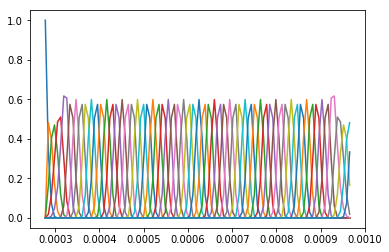

(61, 100)


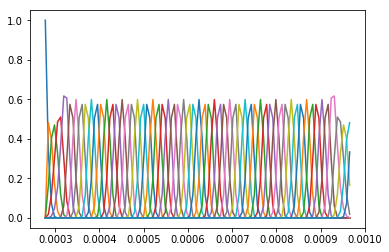

In [21]:
basis = get_basis_Bsplines(knots=Solver.att_knots[0,:], coeffs=Solver.att_coeffs[0,:], k=Solver.k, obs_times=my_times)
for b in basis:
    plt.plot(my_times, b)
print(basis.shape)

/home/zampieri/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


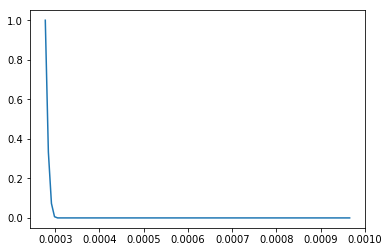

In [30]:
fig = plt.figure()
plt.plot(my_times, basis[0])
fig.show()

In [31]:
np.zeros(5)

array([0., 0., 0., 0., 0.])

In [32]:
Solver.verbose=False
Solver.reset_iterations()
Solver.iterate(5)

***** Iteration: 1 *****


LinAlgError: Singular matrix

In [ ]:
error = error_in_attitude(my_times, Solver, gaia)
print(error)